# all scores scikit-learn - overfitting example :) 

## In this notebook:

* single input dataframe 
* using all scores: dropping missing data
* model: random forest and SVM
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.924
* aucuracy assessement of SVM:  0.895 (rbf), 0.92(linear), 0.71 (sigmoid, predicts alll 1)
* feature importance for RF

In [5]:
import pandas as pd

df_all = pd.read_csv('../data/chr14.out_scores.tsv', sep='\t', encoding = "UTF-8")
df_all = df_all.set_index(['chr','pos', 'ref', 'alt']) #index by identifier

for c in range (15,22):
    #print(c)
    path = '../data/chr' + str(c) + '.out_scores.tsv'
    df = pd.read_csv(path, sep='\t', encoding = "UTF-8")
    df = df.set_index(['chr','pos', 'ref', 'alt']) #index by identifier
    df_all= df_all.append(df)
    
df_all.shape

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(63446, 28)

In [13]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


#df_20 = pd.read_csv('../data/chr20.out_scores.tsv', sep='\t', encoding = "UTF-8")
#df_20 = df_20.set_index(['chr','pos', 'ref', 'alt']) #index by identifier

#df = df_20.copy()
#df_19 = pd.read_csv('../data/chr19.out_scores.tsv', sep='\t', encoding = "UTF-8")
#df_19 = df_19.set_index(['chr','pos', 'ref', 'alt']) #index by identifier


#df_18 = pd.read_csv('../data/chr18.out_scores.tsv', sep='\t', encoding = "UTF-8")
#df_18 = df_18.set_index(['chr','pos', 'ref', 'alt']) #index by identifier



#df_1819 = df_18.append(df_19)
#print("18, 19", df_1819.shape)
#df = df_1819.append(df_20)
#print(df.to_string()) ## will print the whole dataframe
#df.plot.hist()


## pull in pickled dataframe:
df = pd.read_pickle("./pickled_df/all_scores_chr14,22.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
#df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (14929, 28)
shape after dropping all data with score = '.' (14929, 28)
shape after dropping Unk (14929, 28)


In [14]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                     SIFT_score SIFT4G_score Polyphen2_HDIV_score  \
chr pos      ref alt                                                
19  12813135 C   A        0.003        0.005                0.995   
14  36663043 G   A          0.0          0.0                  1.0   
19  12806782 G   A            0            0                  1.0   

                     Polyphen2_HVAR_score LRT_score MutationTaster_score  \
chr pos      ref alt                                                       
19  12813135 C   A                  0.895  0.000020             0.999842   
14  36663043 G   A                    1.0  0.000000                    1   
19  12806782 G   A                    1.0  0.000047                    1   

                     MutationAssessor_score FATHMM_score PROVEAN_score  \
chr pos      ref alt                                                     
19  12813135 C   A                     1.48        -1.83         -5.57   
14  36663043 G   A           

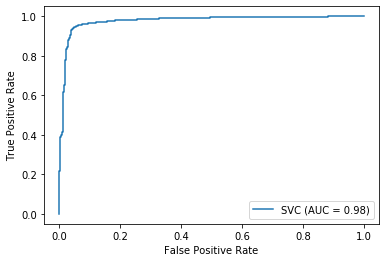

y true [1 1 1 ... 0 0 1]
y predicted [1 0 1 ... 0 0 1]
Confusion matrix: 
 [[ 870   92]
 [  97 2597]]
Accuracy: 0.9483041575492341
Recall TP/(TP+FN): [0.9043659  0.96399406]
Precision TP/(TP+FP): [0.89968976 0.96578654]
F1: [0.90202177 0.96488947]


In [15]:
## Try a binary support vector machine:

classifier1 = SVC(kernel='rbf', gamma='scale',random_state=42) # default for kernel and gamma. AUC = 0.94
classifier2 = SVC(kernel='linear', gamma=10 ,random_state=42) # 0.94
classifier3 = SVC(kernel='sigmoid', gamma=10 ,random_state=42) # 0.82

classifier2.fit(df_train, train_labels)
svc_disp = plot_roc_curve(classifier2, df_test, test_labels)
plt.show()


### Run some stats to see if the model is doing well. 
### Note: for chr20, there are 696 exampels that pass, meaning 25% used for testing gives low numbers, see cm
y_true = test_labels.to_numpy()
y_pred = classifier2.predict(df_test)


print("y true", y_true) ## These are both numpy arrays now, why are the metrics returning arrays rather than single f
print("y predicted", y_pred)

## see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

In [16]:
#type(y_true.to_numpy())  # pandas.core.series.Series
#type(y_pred) # numpy.ndarray

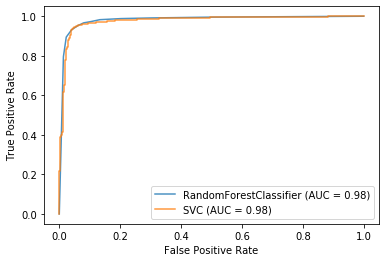

Accuracy: 0.9543216630196937
Confusion matrix: 
 [[ 885   77]
 [  90 2604]]
Feature ranking:
1. feature 1 (0.113184)
SIFT4G_score
2. feature 20 (0.111174)
fathmm-MKL_coding_score
3. feature 10 (0.086657)
MetaSVM_score
4. feature 14 (0.082440)
MutPred_score
5. feature 19 (0.081023)
DANN_score
6. feature 0 (0.065707)
SIFT_score
7. feature 12 (0.065628)
M-CAP_score
8. feature 13 (0.064994)
REVEL_score
9. feature 9 (0.052498)
VEST4_score
10. feature 7 (0.042992)
FATHMM_score
11. feature 5 (0.037401)
MutationTaster_score
12. feature 15 (0.035605)
MVP_score
13. feature 17 (0.029814)
PrimateAI_score
14. feature 11 (0.023019)
MetaLR_score
15. feature 21 (0.016819)
fathmm-XF_coding_score
16. feature 24 (0.010718)
GM12878_fitCons_score
17. feature 4 (0.009419)
LRT_score
18. feature 26 (0.008959)
HUVEC_fitCons_score
19. feature 25 (0.008458)
H1-hESC_fitCons_score
20. feature 22 (0.008358)
GenoCanyon_score
21. feature 18 (0.007887)
DEOGEN2_score
22. feature 23 (0.007846)
integrated_fitCons_score
2

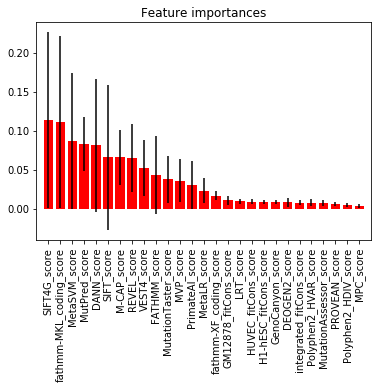

In [42]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)
print("Accuracy:", accuracy_score(y_true, y_pred))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))


## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()